**Import library**


In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, LSTM, Input, GlobalAveragePooling1D, Flatten
from tensorflow.keras import Sequential
import tensorflow_hub as hub
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [4]:
! pip install tensorflow_text
import tensorflow_text as text


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Getting data from github**

In [5]:
train_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_train.csv')
val_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_valid.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/savan77/EmotionDetectionBERT/master/nlp_test.csv')

In [6]:
train_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,He was answering a question about the criticis...,1,0,1,0,0,0,0,1,0,0,0,0
1,1,I'm going to start today's discussion thread w...,1,1,1,1,0,0,0,1,0,0,0,0
2,2,"By announcing the 395 self-quarantined, it pai...",1,1,1,1,0,0,0,1,0,0,0,0
3,3,"Likewise, sorry if I offended you. I’m not act...",1,0,1,1,0,0,0,1,0,0,0,0
4,4,"People infected by experience high fever, coug...",0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
val_data.head()


,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0.0,He was answering a question about the criticis...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,I'm going to start today's discussion thread w...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2.0,"By announcing the 395 self-quarantined, it pai...",1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,3.0,"Likewise, sorry if I offended you. I’m not act...",1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.0,"People infected by experience high fever, coug...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
test_data.head()

,id,text,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust,neutral
0,0,&gt; # First passengers exit quarantined Japan...,0,1,0,1,0,0,1,0,1,0,0,0
1,1,"This is the best tl;dr I could make, [original...",0,0,0,0,0,0,0,0,0,0,0,1
2,2,Absolutely. Trade is good for everyone.\n\nBut...,0,0,1,0,0,0,0,0,0,0,0,0
3,3,He says the elderly should stay home. I have t...,0,0,0,1,0,0,0,1,0,0,0,0
4,4,&gt; A couple of million wont die in the US.\n...,0,1,0,1,0,0,0,1,1,1,0,0


In [9]:
train_sentiment_data = train_data.dropna()
train_sentiment_data = train_sentiment_data.reset_index(drop=True)

val_sentiment_data = val_data.dropna()
val_sentiment_data = val_sentiment_data.reset_index(drop=True)

test_sentiment_data = test_data.dropna()
test_sentiment_data = test_sentiment_data.reset_index(drop=True)

In [10]:
label_class = ['anger',	'anticipation',	'disgust',	'fear',	'joy'	,'love',	'optimism',	'pessimism'	,'sadness'	,'surprise',	'trust'	,'neutral']
input_data_train = train_sentiment_data['text'].values
label_data_train = train_sentiment_data[label_class].values

In [11]:
input_data_val = val_sentiment_data['text'].values
label_data_val = val_sentiment_data[label_class].values

input_data_test = test_sentiment_data['text'].values
label_data_test = test_sentiment_data[label_class].values

**Training with Pretrain Word Embedding**

In [18]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype = tf.string, trainable=True)
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(12, activation='sigmoid'))
model.summary()

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold =0.5
))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_3 (Dense)             (None, 32)                1632      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 12)                204       
                                                                 
Total params: 48,192,964
Trainable params: 48,192,964
Non-trainable params: 0
_________________________________________________________________


In [21]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_google_embedding.h5', monitor='val_loss')
history = model.fit(
    x=input_data_train, y = label_data_train, epochs = 50, 
    validation_data=(input_data_val, label_data_val), callbacks=[callback_model]
)

47/47 [==============================] - 31s 641ms/step - loss: 0.6693 - binary_accuracy: 0.6066 - val_loss: 0.6446 - val_binary_accuracy: 0.6763
Epoch 2/50
47/47 [==============================] - 27s 576ms/step - loss: 0.5961 - binary_accuracy: 0.7148 - val_loss: 0.5580 - val_binary_accuracy: 0.7313
Epoch 3/50
47/47 [==============================] - 30s 641ms/step - loss: 0.5369 - binary_accuracy: 0.7484 - val_loss: 0.5061 - val_binary_accuracy: 0.7626
Epoch 4/50
47/47 [==============================] - 40s 855ms/step - loss: 0.4950 - binary_accuracy: 0.7735 - val_loss: 0.4657 - val_binary_accuracy: 0.7838
Epoch 5/50
47/47 [==============================] - 41s 863ms/step - loss: 0.4558 - binary_accuracy: 0.7941 - val_loss: 0.4238 - val_binary_accuracy: 0.8091
Epoch 6/50
47/47 [==============================] - 37s 784ms/step - loss: 0.4140 - binary_accuracy: 0.8197 - val_loss: 0.3776 - val_binary_accuracy: 0.8394
Epoch 7/50
47/47 [==============================] - 26s 556ms/step - 

In [22]:
model.load_weights('model_google_embedding.h5')
model.evaluate(input_data_test, label_data_test)
preds = model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test, preds, target_names=label_class, zero_division=0))

12/12 [==============================] - 1s 71ms/step
              precision    recall  f1-score   support

       anger       0.60      0.58      0.59       121
anticipation       0.71      0.64      0.67       218
     disgust       0.69      0.75      0.72       156
        fear       0.69      0.57      0.62       195
         joy       0.40      0.09      0.14        70
        love       0.27      0.10      0.15        30
    optimism       0.40      0.34      0.37        97
   pessimism       0.50      0.63      0.56       120
     sadness       0.45      0.26      0.33       136
    surprise       0.27      0.06      0.10        49
       trust       0.50      0.17      0.25        60
     neutral       0.60      0.08      0.14        38

   micro avg       0.59      0.47      0.52      1290
   macro avg       0.51      0.35      0.39      1290
weighted avg       0.57      0.47      0.49      1290
 samples avg       0.50      0.44      0.43      1290



**Training with Bert**

In [20]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2', trainable=False, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]  
  net = tf.keras.layers.Dense(400, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(200, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(100, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(50, activation='relu')(net)
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(12, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(inputs= text_input, outputs = net)

classifier_model = build_classifier_model()
classifier_model.summary()
adam = Adam(learning_rate=0.001)
metric_acc = tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", dtype=None, threshold=0.5)
classifier_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=metric_acc)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

In [21]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_small_bert.h5', monitor='val_loss')
history = classifier_model.fit(
    x=input_data_train, y = label_data_train, epochs = 50, 
    validation_data=(input_data_val, label_data_val), callbacks=[callback_model]
)

Epoch 1/50
47/47 [==============================] - 263s 5s/step - loss: 0.5589 - binary_accuracy: 0.7048 - val_loss: 0.5290 - val_binary_accuracy: 0.7172
Epoch 2/50
47/47 [==============================] - 254s 5s/step - loss: 0.5333 - binary_accuracy: 0.7256 - val_loss: 0.5116 - val_binary_accuracy: 0.7343
Epoch 3/50
47/47 [==============================] - 260s 5s/step - loss: 0.5186 - binary_accuracy: 0.7372 - val_loss: 0.4977 - val_binary_accuracy: 0.7505
Epoch 4/50
47/47 [==============================] - 254s 5s/step - loss: 0.5126 - binary_accuracy: 0.7390 - val_loss: 0.4919 - val_binary_accuracy: 0.7591
Epoch 5/50
47/47 [==============================] - 250s 5s/step - loss: 0.5070 - binary_accuracy: 0.7482 - val_loss: 0.4856 - val_binary_accuracy: 0.7677
Epoch 6/50
47/47 [==============================] - 274s 6s/step - loss: 0.5039 - binary_accuracy: 0.7504 - val_loss: 0.5136 - val_binary_accuracy: 0.7545
Epoch 7/50
47/47 [==============================] - 253s 5s/step - los

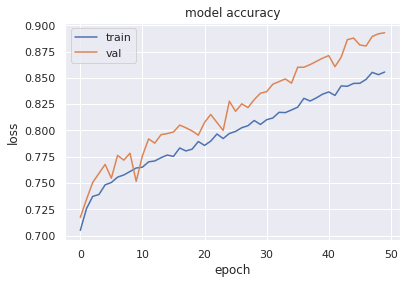

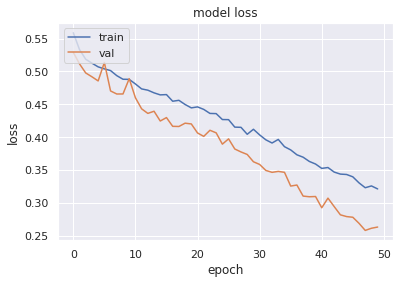

In [22]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
classifier_model.load_weights('model_small_bert.h5')
classifier_model.evaluate(input_data_test, label_data_test)
preds = classifier_model.predict(input_data_test)
preds = tf.round(preds).numpy()
print(classification_report(label_data_test, preds, target_names=label_class, zero_division=0))

12/12 [==============================] - 57s 5s/step
              precision    recall  f1-score   support

       anger       0.57      0.49      0.53       121
anticipation       0.70      0.58      0.63       218
     disgust       0.64      0.63      0.63       156
        fear       0.73      0.46      0.56       195
         joy       0.46      0.16      0.23        70
        love       0.29      0.07      0.11        30
    optimism       0.46      0.46      0.46        97
   pessimism       0.44      0.48      0.46       120
     sadness       0.58      0.19      0.29       136
    surprise       0.00      0.00      0.00        49
       trust       0.31      0.18      0.23        60
     neutral       0.30      0.45      0.36        38

   micro avg       0.57      0.42      0.48      1290
   macro avg       0.46      0.35      0.37      1290
weighted avg       0.55      0.42      0.46      1290
 samples avg       0.48      0.41      0.41      1290



In [32]:
test_input = "He was answering a question about the criticism by the same individual s that were referring to it as The Chinese and Wuhan Corona Virus last week. But I guess blind hatred negates the ability to look at things objectively. Is he a jackass? Yes, but this constant negativity from the moment he was nominated is exhausting."

def predict_sentiment(input, model):
  pred_result = classifier_model.predict([test_input])
  pred_result = list(tf.round(pred_result).numpy()[0])
  for v, l in zip(pred_result, label_class):
    if v == 1.0:
      print(l)
predict_sentiment(test_input, classifier_model)

1/1 [==============================] - 0s 338ms/step
anger
disgust


**Training with traditional Bidirectional-LSTM**

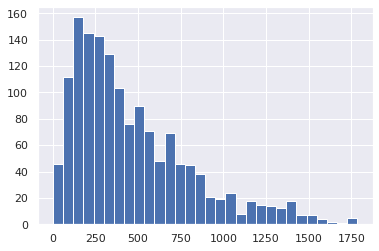

In [12]:
# chuyển về vector số có cùng chiều dài
seq_len = [len(i.split()) for i in input_data_train]
pd.Series(seq_len).hist(bins = 30)

In [13]:
tokenizer_data = Tokenizer(oov_token ='oov', filters ='', split= ' ')
tokenizer_data.fit_on_texts(input_data_train)

tokenized_data_train = tokenizer_data.texts_to_sequences(input_data_train)
vec_data_train = pad_sequences(tokenized_data_train, padding ='post', maxlen = 250)

tokenized_data_val = tokenizer_data.texts_to_sequences(input_data_val)
vec_data_val = pad_sequences(tokenized_data_val, padding ='post', maxlen = 250)
data_vocab_size = len(tokenizer_data.word_index)+1
print("Input vector training:", vec_data_train.shape)
print("Input vector val:", vec_data_val.shape)
print("vocab size:", data_vocab_size)

Input vector training: (1493, 250)
Input vector val: (165, 250)
vocab size: 69258


In [14]:
# Training with traditional LSTM + RNN

dropoutt_threshold = 0.4
model = Sequential()
input_dim = data_vocab_size
output_dim = 60
input_length = 250

#Add embedding layer
model.add(Embedding(input_dim = input_dim, output_dim = output_dim, input_length=input_length ))

#Add bidirectional LSTM
model.add(Bidirectional(LSTM(units= output_dim, dropout =dropoutt_threshold, return_sequences=True ), merge_mode = 'concat'))

model.add(Bidirectional(LSTM(units= output_dim,  return_sequences=True )))
model.add(GlobalAveragePooling1D())
model.add(Dense(500, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(200, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(100, activation ='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation ='relu'))
model.add(Dense(12, activation ='sigmoid'))

adam = Adam(learning_rate = 0.001)
model.compile(optimizer=adam, loss='binary_crossentropy', metrics = tf.keras.metrics.BinaryAccuracy(
    name ="binary_accuracy", dtype=None, threshold = 0.5
))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 60)           4155480   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 120)         58080     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 250, 120)         86880     
 nal)                                                            
                                                                 
 global_average_pooling1d (G  (None, 120)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 500)               60500     
                                                        

In [15]:
callback_model = tf.keras.callbacks.ModelCheckpoint('model_lstm.h5', monitor='val_loss')
history = model.fit(
    x=vec_data_train, y = label_data_train, epochs = 50, 
    validation_data=(vec_data_val, label_data_val), callbacks=[callback_model]
)

Epoch 1/50
47/47 [==============================] - 48s 669ms/step - loss: 0.5837 - binary_accuracy: 0.6880 - val_loss: 0.5365 - val_binary_accuracy: 0.7172
Epoch 2/50
47/47 [==============================] - 32s 682ms/step - loss: 0.5302 - binary_accuracy: 0.7216 - val_loss: 0.5128 - val_binary_accuracy: 0.7227
Epoch 3/50
47/47 [==============================] - 32s 678ms/step - loss: 0.4927 - binary_accuracy: 0.7441 - val_loss: 0.4536 - val_binary_accuracy: 0.7793
Epoch 4/50
47/47 [==============================] - 29s 627ms/step - loss: 0.4490 - binary_accuracy: 0.7659 - val_loss: 0.4202 - val_binary_accuracy: 0.7869
Epoch 5/50
47/47 [==============================] - 30s 631ms/step - loss: 0.4276 - binary_accuracy: 0.7770 - val_loss: 0.3876 - val_binary_accuracy: 0.8141
Epoch 6/50
47/47 [==============================] - 30s 629ms/step - loss: 0.4024 - binary_accuracy: 0.7919 - val_loss: 0.3755 - val_binary_accuracy: 0.8217
Epoch 7/50
47/47 [==============================] - 29s 62

In [16]:
tokenized_data_test = tokenizer_data.texts_to_sequences(input_data_test)
vec_data_test= pad_sequences(tokenized_data_test,padding='post', maxlen =250)
model.load_weights('model_lstm.h5')
model.evaluate(vec_data_test, label_data_test)
preds= model.predict(vec_data_test)
preds = tf.round(preds).numpy()

print(classification_report(label_data_test, preds, target_names=label_class, zero_division=0))

12/12 [==============================] - 3s 126ms/step
              precision    recall  f1-score   support

       anger       0.45      0.72      0.55       121
anticipation       0.68      0.49      0.57       218
     disgust       0.52      0.76      0.61       156
        fear       0.61      0.58      0.60       195
         joy       0.41      0.10      0.16        70
        love       1.00      0.03      0.06        30
    optimism       0.26      0.32      0.29        97
   pessimism       0.41      0.59      0.48       120
     sadness       0.45      0.37      0.41       136
    surprise       0.19      0.22      0.21        49
       trust       0.30      0.17      0.22        60
     neutral       0.71      0.13      0.22        38

   micro avg       0.48      0.47      0.47      1290
   macro avg       0.50      0.37      0.36      1290
weighted avg       0.50      0.47      0.46      1290
 samples avg       0.45      0.44      0.41      1290

